In [1]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.llms.google_genai import GoogleGenAI
from llama_index.llms.groq import Groq
from llama_index.core import VectorStoreIndex
import google.genai.types as types
from google import genai
import nest_asyncio


nest_asyncio.apply()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
COHERE_API_KEY = os.getenv("COHERE_API_KEY")
SEARCH_ENGINE_ID = os.getenv('GOOGLE_SEARCH_ENGINE')
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
# model = "gemini-2.5-flash-preview-09-2025"
# model = "gemini-2.5-flash"
model = "llama-3.1-8b-instant"
embedding_model = "intfloat/e5-small-v2"

# config = types.GenerateContentConfig(
#     thinking_config=types.ThinkingConfig(thinking_budget=0),
#     temperature=0.4 # set this to make this less chatty and more deterministic to save the tokens
# )

# llm = GoogleGenAI(
#     model=model,
#     generation_config=config,
# )

# Settings.llm = llm

Settings.embed_model = HuggingFaceEmbedding(
    model_name=embedding_model,
    device="cpu"                    # Use "cuda" if you have a GPU
)
Settings.text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=128)


# client = genai.Client()
# model_info = client.models.get(model=model)
# print(f"{model_info.input_token_limit=}")
# print(f"{model_info.output_token_limit=}")

Settings.llm = Groq(
    model="llama-3.1-8b-instant", 
    api_key=GROQ_API_KEY
)



e:\Extra Learning Resources\Extra Learning Resources\NLP\RAG\Practice Learning\venv_rag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is to test whether the LLM is working fine!

In [ ]:
# try:
#     test_response = Settings.llm.complete("What is the capital of France?")
#     print(f"Test Response: {test_response}")
#     print("LLM Status: Success!")
# except Exception as e:
#     print(f"LLM Status: Failed")
#     print(f"Error Details: {e}")

Test Response: The capital of France is Paris.
LLM Status: Success!


The TokenTextSplitter focuses strictly on the count of tokens. It doesn't care about grammar, periods, or paragraphs; it only cares about the math

In [2]:
llm

GoogleGenAI(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x000002E1B2D593D0>, system_prompt=None, messages_to_prompt=<function messages_to_prompt at 0x000002E1901B2840>, completion_to_prompt=<function default_completion_to_prompt at 0x000002E190526200>, output_parser=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>, query_wrapper_prompt=None, model='gemini-2.5-flash', temperature=0.1, context_window=None, max_retries=3, is_function_calling_model=True, cached_content=None, built_in_tool=None)

## Load the Dataset (JSON)

The dataset includes several articles from the TowardsAI blog, Research paper contents and Documentation which provide an in-depth explanation of AI models and RAG method.

In [5]:
from huggingface_hub import hf_hub_download
import json

file_path = hf_hub_download(
    repo_id="jaiganesan/ai_tutor_knowledge", 
    filename="ai_tutor_knowledge.jsonl", 
    repo_type="dataset"
    )

# Exploring the dataset content
with open(file_path, "r") as file:
    ai_tutor_knowledge = [json.loads(line) for line in file]

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: ec5d544e-9685-45ca-b310-37815b2220d2)')' thrown while requesting HEAD https://huggingface.co/datasets/jaiganesan/ai_tutor_knowledge/resolve/main/ai_tutor_knowledge.jsonl
Retrying in 1s [Retry 1/5].


In [6]:
ai_tutor_knowledge[1]

{'tokens': 3031,
 'doc_id': '833ebd5f-b647-5b96-8eae-d6ee7c8eb2b1',
 'name': 'Named Entity Recognition in Ecommerce Industry  Custom model [Github Repo]  03/07/24',
 'url': 'https://towardsai.net/p/machine-learning/named-entity-recognition-in-ecommerce-industry-custom-model-github-repo-03-07-24',
 'source': 'tai_blog',
 'content': "Github Repo: https://github.com/vaibhawkhemka/ML-Umbrella/tree/main/NLP/Product-Categorization   From e-commerce to Customer support  all businesses require some kind of NER model to process huge amounts of texts from users.   To automate this whole  one requires NER models to extract relevant and important entities from text.   Final Result/OutputInput text = EL D68 (Green  32 GB) 3 GB RAM [3 GB RAM U+007C 32 GB ROM U+007C Expandable Upto 128 GB  15.46 cm (6.088 inch) Display  13MP Rear Camera U+007C 8MP Front Camera  4000 mAh Battery  Quad-Core Processor]   Output =   Green ->>>> COLOR 32 GB ->>>> STORAGE 3 GB RAM ->>>> RAM 3 GB RAM ->>>> RAM 32 GB ROM ->>

In [7]:
from typing import List, Dict
from llama_index.core import Document

def create_docs_from_list(dataList: List[Dict]) -> List[Document]:
    documents = []
    for data in dataList:
        documents.append(
            Document(
                doc_id=data["doc_id"],
                text=data["content"],
                # Only the data you explicitly put in those fields (content, url, name, etc.) 
                # will exist in that Document object from which you can exclude or include metadata keys.
                metadata={  
                    "url": data["url"],
                    "title": data["name"],
                    "tokens": data["tokens"],
                    "source": data["source"],
                },
                excluded_llm_metadata_keys=[
                    "title",
                    "tokens",
                    "source",
                ],
                excluded_embed_metadata_keys=[
                    "url",
                    "tokens",
                    "source",
                ],
            )
        )
    return documents

doc = create_docs_from_list(ai_tutor_knowledge)
doc[2]

Document(id_='45501b72-9391-529e-8e5e-59a2604ba26e', embedding=None, metadata={'url': 'https://towardsai.net/p/machine-learning/adaboost-explained-from-its-original-paper', 'title': 'AdaBoost Explained From Its Original Paper', 'tokens': 1697, 'source': 'tai_blog'}, excluded_embed_metadata_keys=['url', 'tokens', 'source'], excluded_llm_metadata_keys=['title', 'tokens', 'source'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text="This publication is meant to show a very popular ML algorithm in complete detail  how it works  the math behind it  how to execute it in Python and an explanation of the proofs of the original paper. There will be math and code  but it is written in a way that allows you to decide which are the fun parts.   A bit on the origins of the algorithm: It was proposed by Yoav Freund and Robert E. Schapire in a 1997 paper  A Decision-Theoretic Generalization of On-Line Learning a

In [8]:
len(doc)

762

In [9]:
from llama_index.core.ingestion import IngestionPipeline
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb

# Uncomment the below lines to delete existing collection and start fresh

# try:
#     db.delete_collection("./mini-llama-articles/ai_tutor_knowledge")
#     print("Collection deleted. Starting fresh!")
# except:
#     print("Collection didn't exist or was already deleted.")


# save to disk
db = chromadb.PersistentClient(path="./mini-llama-articles/ai_tutor_knowledge")
chroma_collection = db.get_or_create_collection("ai_tutor_knowledge")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)

In [ ]:
from llama_index.core.extractors import(
    SummaryExtractor,
    QuestionsAnsweredExtractor,
    KeywordExtractor,
)


pipeline = IngestionPipeline(
    transformations=[
        Settings.text_splitter,
        QuestionsAnsweredExtractor(
            questions=2, 
            prompt_template="Extract 2 short questions from: {context_str}. Be very brief."
        ),
        SummaryExtractor(
            summaries=["prev", "self"], 
            prompt_template="Summary should be concised from context: {context_str}"
            ),
        KeywordExtractor(
            keywords=5, 
            ),
        Settings.embed_model
    ],
    vector_store=vector_store,
)

# Run the transformation pipeline.
# setting the num_worker to 1 to avoid issues with chromadb and multiprocessing and doesn't bombard the LLM with too many parallel requests
nodes = pipeline.run(documents=doc, show_progress=True, num_workers=1)

  0%|          | 13/5834 [00:15<3:15:35,  2.02s/it]Retrying llama_index.llms.openai.base.OpenAI._achat in 1.0 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kenfpe4ke9qac7vk76zdrw2f` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5878, Requested 581. Please try again in 4.59s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}.
Retrying llama_index.llms.openai.base.OpenAI._achat in 1.0 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01kenfpe4ke9qac7vk76zdrw2f` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5840, Requested 572. Please try again in 4.12s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'typ

In [14]:
import nest_asyncio
nest_asyncio.apply()

new_pip = IngestionPipeline(
    transformations=[
        Settings.text_splitter,
        QuestionsAnsweredExtractor(
            questions=2, 
            # llm=ingestion_llm, 
            prompt_template="Extract 2 short questions from: {context_str}. Be very brief."
        ),
        SummaryExtractor(
            summaries=["self"], 
            # llm=ingestion_llm,
            prompt_template="Summarize this in one short sentence: {context_str}"
        ),
        Settings.embed_model
    ],
    # vector_store=vector_store,
)

nodes = new_pip.run(documents=doc[:2], show_progress=True, num_workers=1)

Generating embeddings: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


In [7]:
doc[0]

Document(id_='d72b4670-84f0-54a3-b259-7eb7f218674e', embedding=None, metadata={'url': 'https://towardsai.net/p/machine-learning/bert-huggingface-model-deployment-using-kubernetes-github-repo-03-07-2024', 'title': 'BERT HuggingFace Model Deployment using Kubernetes [ Github Repo]  03/07/2024', 'tokens': 768, 'source': 'tai_blog'}, excluded_embed_metadata_keys=['url', 'tokens', 'source'], excluded_llm_metadata_keys=['title', 'tokens', 'source'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='Github Repo : https://github.com/vaibhawkhemka/ML-Umbrella/tree/main/MLops/Model_Deployment/Bert_Kubernetes_deployment   Model development is useless if you dont deploy it to production  which comes with a lot of issues of scalability and portability.   I have deployed a basic BERT model from the huggingface transformer on Kubernetes with the help of docker  which will give a feel of how to deploy and manage

# Cost Estimation and Analysis

In [ ]:
from llama_index.core.llms import MockLLM
import tiktoken
from llama_index.core import Settings
from llama_index.core.callbacks import CallbackManager, TokenCountingHandler

import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core.extractors import(
    SummaryExtractor,
    QuestionsAnsweredExtractor,
    KeywordExtractor,
)
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core import MockEmbedding


token_counter = TokenCountingHandler(
    tokenizer=tiktoken.get_encoding("cl100k_base").encode,
    verbose=True,
)
Settings.callback_manager = CallbackManager([token_counter])
# max_tokens=256 here acts as a "worst case" prediction for every call
# max_token cuts down the cost, for every summary and questions answered is generate
# this will limit the max tokens generated per call, it means no more than 300 tokens will be generated per call
# You can see the example run first 2 are the questions answered, next 2 are the summaries, last is the keywords
Settings.llm = MockLLM(max_tokens=300)  
Settings.embed_model = MockEmbedding(embed_dim=1024)

pipeline = IngestionPipeline(
    transformations=[
        Settings.text_splitter,
        QuestionsAnsweredExtractor(questions=2),
        SummaryExtractor(summaries=["prev", "self"]),
        KeywordExtractor(keywords=5),
        Settings.embed_model
    ],
    # vector_store=vector_store,
)

# Run the transformation pipeline.
# nodes = pipeline.run(documents=doc, show_progress=True)

# 3. Run the pipeline (It will be instant and cost $0)
await pipeline.arun(documents=doc, show_progress=True)

# 4. Print token counts (use the correct variable name)
print("=" * 50)
print(f"Embedding Tokens: {token_counter.total_embedding_token_count}")
print(f"Prompt Tokens: {token_counter.prompt_llm_token_count}")
print(f"Completion Tokens: {token_counter.completion_llm_token_count}")
print(f"Total LLM Tokens: {token_counter.total_llm_token_count}")
print("=" * 50)

INPUT_RATE_PER_M = 0.30  
OUTPUT_RATE_PER_M = 2.00 # Excluding the thinking tokens approx

# To calculate per single token:
INPUT_COST = INPUT_RATE_PER_M / 1_000_000
OUTPUT_COST = OUTPUT_RATE_PER_M / 1_000_000

estimated_cost = (
    token_counter.prompt_llm_token_count * INPUT_COST +
    token_counter.completion_llm_token_count * OUTPUT_COST
)
print(f"\nEstimated Cost: ${estimated_cost:.4f}")

  0%|          | 0/2584 [00:00<?, ?it/s]

LLM Prompt Token Usage: 904
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 904
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 884
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 884
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1100
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1100
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 805
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 805
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 821
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 821
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 362
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 362
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1054
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1054
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1069
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1069
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1097
LLM C

  0%|          | 0/2584 [00:00<?, ?it/s]

LLM Prompt Token Usage: 1362
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1362
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 918
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 918
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1387
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1387
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1364
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1364
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 613
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 613
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1371
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1371
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1351
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1351
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1386
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1386
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1356

  0%|          | 0/2584 [00:00<?, ?it/s]

LLM Prompt Token Usage: 1271
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1271
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1881
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1881
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1219
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1219
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1987
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1987
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1456
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1456
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1930
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1930
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1932
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1932
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1806
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 1806
LLM Completion Token Usage: 300
LLM Prompt Token Usage: 

Generating embeddings: 100%|██████████| 259/259 [00:00<00:00, 3591.95it/s]

Embedding Token Usage: 19789
Embedding Token Usage: 20558
Embedding Token Usage: 20626
Embedding Token Usage: 20399
Embedding Token Usage: 21365
Embedding Token Usage: 19911


Embedding Token Usage: 21350
Embedding Token Usage: 21136
Embedding Token Usage: 21292
Embedding Token Usage: 21111
Embedding Token Usage: 21867
Embedding Token Usage: 19819
Embedding Token Usage: 21040
Embedding Token Usage: 21735
Embedding Token Usage: 20570
Embedding Token Usage: 19847
Embedding Token Usage: 21445
Embedding Token Usage: 20246
Embedding Token Usage: 19712
Embedding Token Usage: 20509
Embedding Token Usage: 21324
Embedding Token Usage: 21851
Embedding Token Usage: 21728
Embedding Token Usage: 21288
Embedding Token Usage: 20152
Embedding Token Usage: 21426
Embedding Token Usage: 21726
Embedding Token Usage: 20629
Embedding Token Usage: 21056
Embedding Token Usage: 21575
Embedding Token Usage: 19913
Embedding Token Usage: 20656
Embedding Token Usage: 20188
Embedding Token Usage: 20123
Embedding Token Usage: 20971
Embedding Token Usage: 20604
Embedding Token Usage: 20845
Embedding Token Usage: 20216
Embedding Token Usage: 20909
Embedding Token Usage: 21092
Embedding Toke

: 

In [12]:
INPUT_RATE_PER_M = 0.30  
OUTPUT_RATE_PER_M = 2.00 # Excluding the thinking tokens approx

# To calculate per single token:
INPUT_COST = INPUT_RATE_PER_M / 1000000
OUTPUT_COST = OUTPUT_RATE_PER_M / 1000000

estimated_cost = (
    token_counter.prompt_llm_token_count * INPUT_COST +
    token_counter.completion_llm_token_count * OUTPUT_COST
)
print(f"\nEstimated Cost: ${estimated_cost:.4f}")


Estimated Cost: $15.1748


In [14]:
token_counter.prompt_llm_token_count 

19574780

## Performing Data Analysis

--- Dataset Token Statistics ---
count       762.000000
mean       2309.774278
std        6404.039477
min         101.000000
25%         363.000000
50%        1071.500000
75%        2305.250000
max      112398.000000
Name: tokens, dtype: float64


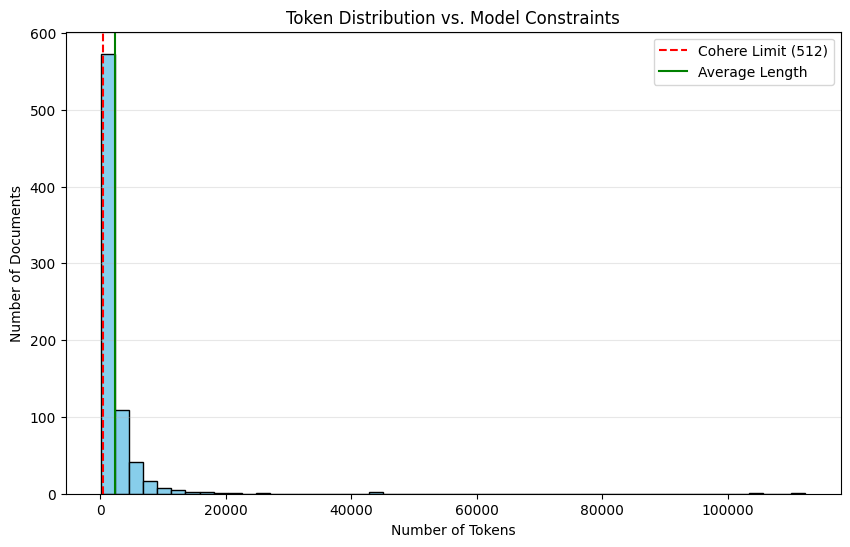


Alert: 517 documents (67.85%) exceed the Cohere embedding limit.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Convert your list of dictionaries to a DataFrame
df = pd.DataFrame(ai_tutor_knowledge)

# 2. Basic Descriptive Statistics
stats = df['tokens'].describe()
print("--- Dataset Token Statistics ---")
print(stats)

# 3. Visualize the Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['tokens'], bins=50, color='skyblue', edgecolor='black')

# 4. Add "Constraint Lines" (The Senior Engineer's View)
plt.axvline(x=512, color='red', linestyle='--', label='Cohere Limit (512)')
plt.axvline(x=stats['mean'], color='green', linestyle='-', label='Average Length')

plt.title('Token Distribution vs. Model Constraints')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Documents')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 5. Outlier Analysis
outliers = df[df['tokens'] > 512].shape[0]
print(f"\nAlert: {outliers} documents ({outliers/len(df)*100:.2f}%) exceed the Cohere embedding limit.")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# PRE-REQUISITE: You must have generated embeddings using Cohere for your 'content'
# Let's assume 'embeddings' is a numpy array of shape (762, 1024)

# 1. Cluster the documents (Topic Modeling)
num_topics = 10 # Start with a guess, then optimize using the "Elbow Method"
kmeans = KMeans(n_clusters=num_topics, random_state=42)
df['topic_cluster'] = kmeans.fit_predict(embeddings)

# 2. Dimensionality Reduction (For Visualization)
# We move from 1024 dimensions down to 2 dimensions so we can see the "map"
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# 3. Visualize the Semantic Space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=df['topic_cluster'], cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Topic Cluster ID')
plt.title('Semantic Map of AI Tutor Knowledge Base')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()